In [1]:
from Solver import Particle, Perceptron, PerceptronModel, VicsekModel, NeuralNetwork, PerceptronMode, Mode, NeuralSwarmModel

import tensorflow as tf
import numpy as np
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

2023-08-01 12:30:09.599524: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-01 12:30:09.625545: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-01 12:30:10.073290: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/renlephy/miniconda3/envs/bachelor/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/renlephy/mini

# Simulation Parameters

In [2]:
# Simulation settings
settings = {
        #                  N,      L,      v,      noise,  r
        "XXsmall": [       5,      4,      0.03,   0.1,    1],
        "Xsmall": [        20,     6,      0.03,   0.1,    1],
        "small": [         100,    30,     0.03,   0.1,    1],
        "a": [             300,    7,      0.03,   2.0,    1],
        "b": [             300,    25,     0.03,   0.5,    1],
        "d": [             300,    5,      0.03,   0.1,    1],
        "plot1_N40": [     40,     3.1,    0.03,   0.1,    1],
        "large": [         2000,   60,     0.03,   0.3,    1]
    }
    
# Choose between RADIUS, FIXED, FIXEDRADIUS
mode = Mode.FIXEDRADIUS
# Flags
ZDimension = False     # 2D or 3D
# Duration of simulation
timesteps = 5000
# Choose settings
chosen_settings = settings["small"]
N       = chosen_settings[0]
L       = chosen_settings[1]
v       = chosen_settings[2]
noise   = chosen_settings[3]
r       = chosen_settings[4]
k_neighbors = 5

# Hyperparameters

In [3]:
# Use "num_iterations = 1e6" for better results (2 hrs)
# 1e5 is just so this doesn't take too long (1 hr)
num_iterations = 100 # @param {type:"integer"}

initial_collect_steps = 10 # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_capacity = 100000 # @param {type:"integer"}

batch_size = 2 # @param {type:"integer"}

critic_learning_rate = 3e-4 # @param {type:"number"}
actor_learning_rate = 3e-4 # @param {type:"number"}
target_update_tau = 0.005 # @param {type:"number"}
target_update_period = 1 # @param {type:"number"}
gamma = 0.99 # @param {type:"number"}
reward_scale_factor = 10.0 # @param {type:"number"}

actor_fc_layer_params = (8, 8)
critic_joint_fc_layer_params = (256, 256)

log_interval = 10 # @param {type:"integer"}

num_eval_episodes = 10 # @param {type:"integer"}
eval_interval = 10 # @param {type:"integer"}

policy_save_interval = 100 # @param {type:"integer"}

# Simulation Environment

In [4]:
from tf_agents.trajectories import time_step as ts
from tf_agents.specs import array_spec
from tf_agents.environments import py_environment


# Create a custom environment
class SimulationEnvironment(py_environment.PyEnvironment):
    """Interface for a swarm simulation environment.
    
    Can be converted into a TensorFlow environment.
    
    Provides uniform access to the simulation and hosts the reward function.
    """
    # [ ] Create a hyperparameter by changing an episode to a certain number of timesteps
    # [ ] Check if this change conflicts with the experience trajectories
    minimum = 0.0
    maximum = 2*np.pi
    logging_flag = True
    
    def __init__(self):
        
        # The action is the angle of the particle
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.float32, minimum=self.minimum, maximum=self.maximum, name='action')
        
        
        # k_neighbors + 1 because the particle itself is also included
        # [ ] Change the observation to a relative angle (this reduces the dimensionality of the observation space by 1)
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(k_neighbors + 1,), dtype=np.float32, minimum=self.minimum, maximum=self.maximum, name='observation')
        
        # Flags and variables
        self._episode_ended = False
        self.simulation = NeuralSwarmModel(N, L, v, noise, r, mode, k_neighbors, ZDimension, seed=False)
        self._state = self.simulation.mean_direction2D()
        # One "episode" and its corresponding reward consists of the iteration over all N particles
        self.index = 0
        # To change all angles at once, we need to store the new angles in a list
        self.new_angles = np.zeros(shape=(N,), dtype=np.float32)
        observation = self.simulation.get_angles(self.index)
        self._current_time_step = ts.restart(np.array(observation, dtype=np.float32))
        

    def observation_spec(self):
        """Return observation_spec."""
        # DONE
        return self._observation_spec

    def action_spec(self):
        """Return action_spec."""
        # DONE
        return self._action_spec
    
    def reset(self):
        """Return initial_time_step and reset the simulation.
        
        Note that this is a hard reset and not a reset for the current epoch."""
        
        # DONE
        self._current_time_step = self._reset()
        return self._current_time_step

    def step(self, action):
        """Apply action and return new time_step."""
        # DONE
        if self._current_time_step is None:
            return self.reset()
        self._current_time_step = self._step(action)
        return self._current_time_step

    def current_time_step(self):
        # DONE
        return self._current_time_step

    # def time_step_spec(self):
        """Return time_step_spec."""
        # DONE
        # return ts.time_step_spec(self.observation_spec())

    def _reset(self):
        """Return initial_time_step and reset the simulation.
        
        Note that this is a hard reset and not a reset for the current epoch."""
        # THOUGHTS: In this case, a differentiation has to be made between an episode and an epoch.
        # The episode ends when all particles have been updated. An epoch ends when the simulation is reset.
        
        # Reset simulation
        self.simulation = NeuralSwarmModel(N, L, v, noise, r, mode, k_neighbors, ZDimension, seed=False)
        self._state = self.simulation.mean_direction2D()
        self._episode_ended = False
        self.index = 0
        observation = self.simulation.get_angles(self.index)
        if self.logging_flag: print('Environment _reset.')
        return ts.restart(np.array(observation, dtype=np.float32))

    def _step(self, action):
        """Apply action and return new time_step.
        This method hosts the reward function."""
        
        
        observation = self.simulation.get_angles(self.index)
        observation = np.array(observation, dtype=np.float32)
        
        if action < self.minimum: action = self.minimum

        if action >= self.minimum and self._episode_ended is False:
            # Update angle of the particle, but don't update the simulation yet
            self.new_angles[self.index] = action
            if self.logging_flag: print(f'Action applied with action = {action}.')
        elif self._episode_ended is False:
            raise ValueError(f'What did you do? This should be a finite float value. Action = {action}.')
        # Check whether nan is in the observation
        elif np.isnan(observation).any():
            raise ValueError(f'The observation contains nan. Observation = {observation}.')
        # Check whether observation is in the correct range (observation is a list)
        elif np.any(observation < self.minimum) or np.any(observation > self.maximum):
            raise ValueError(f'The observation is not in the correct range. Observation = {observation}.')
        
        # Properly handle the case when the episode ends:
        # [x] The episode ends when all particles have been updated
        # [x] The driver needs to work with the updated simulation. So the simulation needs to go on instead of being reset (after self._episode_ended = True)

        if self._episode_ended:
            # Update all angles at once
            self.simulation.update_angles(self.new_angles)
            
            oldState = self._state
            
            self.simulation.update()
            self._state = self.simulation.mean_direction2D()
            
            # The reward is the difference between the new state and the old state.
            # An increase in the order parameter is rewarded, a decrease is punished.
            reward = self._state - oldState
            # The observation (first argument of ts.termination) is the angles of the neighbors of the particle
            self.index = 0
            if self.logging_flag: print(f'Episode ended with reward = {reward}, state = {self._state}, observation = {observation}, action = {self.new_angles}.')
            return ts.termination(observation, reward)
        else:
            self.index += 1
            if self.index >= N:
                self._episode_ended = True
            return ts.transition(observation, reward=0.0, discount=1.0)

# Strategies

With this option, the training can be scaled to multiple GPUs or TPUs, or multiple machines.

For this to work, two steps are necessary:

- The strategy has to be initialised.
- The model must be defined in a strategy scope.

In this project this option is not used, but it is included for completeness.

In [5]:
"""
from tf_agents.train.utils import strategy_utils

# Distribution strategy
# For now, don't use GPU or TPU

strategy = strategy_utils.get_strategy(tpu=False, use_gpu=False)

# All variables and Agents need to be created under strategy.scope()
"""

# Environment wrapping

In [6]:
from tf_agents.networks import network
from tf_agents.train.utils import spec_utils
from tf_agents.environments import tf_py_environment

# There are two networks and two environments: one for training and one for evaluation.
collect_env = SimulationEnvironment()
eval_env = SimulationEnvironment()

# Wrap the environment in a TF environment.
tf_collect_env = tf_py_environment.TFPyEnvironment(collect_env)
tf_eval_env = tf_py_environment.TFPyEnvironment(eval_env)

# For the network to work with the environment, the specs have to be known.
observation_spec, action_spec, time_step_spec = (spec_utils.get_tensor_specs(tf_collect_env))

# Testing Checkpoint

In [7]:
from tf_agents.environments import utils

# Test the python environments

print("Testing the python environments")
print("Testing the collect environment")
utils.validate_py_environment(collect_env, episodes=1)
print("Testing the eval environment")
utils.validate_py_environment(eval_env, episodes=1)

Testing the python environments
Testing the collect environment
Environment _reset.
Action applied with action = 5.994934558868408.
Action applied with action = 2.6533150672912598.
Action applied with action = 0.8836466073989868.
Action applied with action = 1.7107394933700562.
Action applied with action = 0.022165048867464066.
Action applied with action = 1.0893616676330566.
Action applied with action = 5.075008392333984.
Action applied with action = 2.7597925662994385.
Action applied with action = 3.504944324493408.
Action applied with action = 5.4051833152771.
Action applied with action = 0.7129935622215271.
Action applied with action = 1.5518869161605835.
Action applied with action = 2.339186906814575.
Action applied with action = 4.996392726898193.
Action applied with action = 2.927671432495117.
Action applied with action = 0.5019637942314148.
Action applied with action = 4.619950294494629.
Action applied with action = 1.0580670833587646.
Action applied with action = 1.27778220176

### YES! IT WORKS!

# Actor-Critic Networks

In [8]:
from tf_agents.agents.ddpg import critic_network

# Define a network that can learn to predict the action given an observation.
# This is a simple (on demand fully connected) network that takes in an observation and outputs an action.

class ActorNet(network.Network):

  def __init__(self, input_tensor_spec, output_tensor_spec, name='ActorNet'):
    super(ActorNet, self).__init__(
        input_tensor_spec=input_tensor_spec,
        state_spec=())
    self._output_tensor_spec = output_tensor_spec
    # THOUGHTS: For now, only one layer is used. This can be changed later.
    self._sub_layers = [
        tf.keras.layers.Dense(
            action_spec.shape.num_elements(), activation="linear"),
    ]

  def call(self, observations, step_type=(), network_state=()):
    del step_type  # unused.
    
    output = tf.cast(observations, dtype=tf.float32)
    for layer in self._sub_layers:
      output = layer(output)
    actions = tf.reshape(output, [-1] + self._output_tensor_spec.shape.as_list())

    # Scale and shift actions to the correct range if necessary.
    return actions, network_state


# Create the Actor Network
actor_net = ActorNet(
    input_tensor_spec=observation_spec,
    output_tensor_spec=action_spec)


# Critic Network
critic_net = critic_network.CriticNetwork(
      (observation_spec, action_spec),
      observation_fc_layer_params=None,
      action_fc_layer_params=None,
      joint_fc_layer_params=None,
      activation_fn=None,
      kernel_initializer='glorot_uniform',
      last_kernel_initializer='glorot_uniform')

# The critic network is a Q network that takes in an observation and an action and outputs a Q value.
# The observation and the action are frist passed through their own fully connected layers, before being concatenated and passed through a final fully connected layer.
# action_fc_layer_params, joint_fc_layer_params, and activation_fn are the parameters for the fully connected layers and determine the depth and width of the networks.
# The kernel_initializer and last_kernel_initializer are the initializers for the fully connected layers and the final layer respectively.
# They initialize the weights of the network. The default is glorot_uniform, which is a good default for most networks.
# The glorot_uniform initializer draws the weights from a uniform distribution with a range that depends on the number of input and output units.

# DONT USE AN ACTOR DISTRIBUTION NETWORK FOR DDPG AGENTS
# They need a deterministic action output. The actor distribution network is for stochastic policies.

# Agent

In [9]:
from tf_agents.agents.ddpg import ddpg_agent
from tf_agents.train.utils import train_utils

# Initialize the agent

train_step = train_utils.create_train_step()

tf_agent = ddpg_agent.DdpgAgent(
    time_step_spec,
    action_spec,
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.keras.optimizers.Adam(
        learning_rate=actor_learning_rate),
    critic_optimizer=tf.keras.optimizers.Adam(
        learning_rate=critic_learning_rate),
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    td_errors_loss_fn=tf.math.squared_difference,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    train_step_counter=train_step)

tf_agent.initialize()

2023-08-01 12:30:10.955284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-01 12:30:10.978958: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-01 12:30:10.979011: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-01 12:30:10.981806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-01 12:30:10.981865: I tensorflow/compile

# Replay Buffer

In [10]:
import reverb
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils

# Use Reverb, a framework for experience replay developed by DeepMind, to store and sample experience tuples for training.
# Using a samples_per_insert somewhere between 2 and 1000. This is a trade-off between the number of samples that can be drawn from the replay buffer and the number of times the replay buffer needs to be updated.
rate_limiter=reverb.rate_limiters.SampleToInsertRatio(samples_per_insert=3.0, min_size_to_sample=3, error_buffer=3.0)

table_name = 'uniform_table'
table = reverb.Table(
    table_name,
    max_size=replay_buffer_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1))

reverb_server = reverb.Server([table])

# Since the agent needs N steps of experience to make an update, the dataset will need to sample batches of N steps + 1 to allow the agent to learn from a complete transition.

reverb_replay = reverb_replay_buffer.ReverbReplayBuffer(
    tf_agent.collect_data_spec,
    sequence_length= 2,
    table_name=table_name,
    local_server=reverb_server)

# A dataset is created from the replay buffer to be fed to the agent for training. 
dataset = reverb_replay.as_dataset(
      sample_batch_size=batch_size, num_steps=2).prefetch(50)
experience_dataset_fn = lambda: dataset

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmp_2m329dv.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmp_2m329dv
[reverb/cc/platform/default/server.cc:71] Started replay server on port 34499


# Policies

In [11]:
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_py_policy

# Policies
# Create policies from the agent

tf_eval_policy = tf_agent.policy
eval_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_eval_policy, use_tf_function=True)

tf_collect_policy = tf_agent.collect_policy
collect_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_collect_policy, use_tf_function=True)

# Random policy to sample from the environment
random_policy = random_py_policy.RandomPyPolicy(
  collect_env.time_step_spec(), collect_env.action_spec())

# Actors

In [12]:
from tf_agents.train import actor
from tf_agents.metrics import py_metrics
from tf_agents.train import learner

import tempfile

tempdir = tempfile.gettempdir()

# As the Actors run data collection steps, they pass trajectories of (state, action, reward) to the observer, which caches and writes them to the Reverb replay system.

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  reverb_replay.py_client,
  table_name,
  sequence_length= 2,
  stride_length=1)

In [13]:
# We create an Actor with the random policy and collect experiences to seed the replay buffer with.

initial_collect_actor = actor.Actor(
  collect_env,
  random_policy,
  train_step,
  steps_per_run=initial_collect_steps,
  observers=[rb_observer])

initial_collect_actor.run()

Environment _reset.
Action applied with action = 5.578791618347168.
Action applied with action = 1.2024202346801758.
Action applied with action = 5.136950492858887.
Action applied with action = 5.2129316329956055.
Action applied with action = 2.7218916416168213.
Action applied with action = 3.079664468765259.
Action applied with action = 4.729248523712158.
Action applied with action = 4.072814464569092.
Action applied with action = 0.51148921251297.
Action applied with action = 3.3180508613586426.


In [14]:
# Instantiate an Actor with the collect policy to gather more experiences during training.

env_step_metric = py_metrics.EnvironmentSteps()

collect_actor = actor.Actor(
  collect_env,
  collect_policy,
  train_step,
  steps_per_run= 1,
  metrics=actor.collect_metrics(10),
  summary_dir=os.path.join(tempdir, learner.TRAIN_DIR),
  observers=[rb_observer, env_step_metric])

Environment _reset.


In [15]:
# Create an Actor which will be used to evaluate the policy during training.
# actor.eval_metrics(num_eval_episodes) to log metrics later.

eval_actor = actor.Actor(
  eval_env,
  eval_policy,
  train_step,
  episodes_per_run=num_eval_episodes,
  metrics=actor.eval_metrics(num_eval_episodes),
  summary_dir=os.path.join(tempdir, 'eval'),
)

Environment _reset.


# Learners

In [16]:
from tf_agents.train import triggers

# Learners
# The Learner component contains the agent and performs gradient step updates to the policy variables using experience data from the replay buffer.
# After one or more training steps, the Learner can push a new set of variable values to the variable container.

saved_model_dir = os.path.join(tempdir, learner.POLICY_SAVED_MODEL_DIR)

# Triggers to save the agent's policy checkpoints.
learning_triggers = [
    triggers.PolicySavedModelTrigger(
        saved_model_dir,
        tf_agent,
        train_step,
        interval=policy_save_interval),
    triggers.StepPerSecondLogTrigger(train_step, interval=1000),
]

# A strategy can be used here. The predefined strategy would be passed to the learner.
agent_learner = learner.Learner(
  tempdir,
  train_step,
  tf_agent,
  experience_dataset_fn,
  triggers=learning_triggers)

# Metrics and Evaluation

In [17]:
"""
We instantiated the eval Actor with actor.eval_metrics above, which creates most commonly used metrics during policy evaluation:

- Average return. The return is the sum of rewards obtained while running a policy in an environment for an episode, and we usually average this over a few episodes.
- Average episode length.

We run the Actor to generate these metrics.
"""

def get_eval_metrics():
  eval_actor.run()
  results = {}
  for metric in eval_actor.metrics:
    results[metric.name] = metric.result()
  return results

metrics = get_eval_metrics()

def log_eval_metrics(step, metrics):
  eval_results = (', ').join(
      '{} = {:.6f}'.format(name, result) for name, result in metrics.items())
  print('step = {0}: {1}'.format(step, eval_results))

log_eval_metrics(0, metrics)

Action applied with action = 0.5201982855796814.
Action applied with action = 0.5201982855796814.
Action applied with action = 0.45424455404281616.
Action applied with action = 0.297562837600708.
Action applied with action = 0.009948015213012695.
Action applied with action = 0.26990699768066406.
Action applied with action = 0.5022057294845581.
Action applied with action = 0.43795421719551086.
Action applied with action = 0.3305937945842743.
Action applied with action = 0.053896788507699966.
Action applied with action = 0.04739867150783539.
Action applied with action = 0.4482254087924957.
Action applied with action = 0.3933533728122711.
Action applied with action = 0.3142130970954895.
Action applied with action = 0.10513055324554443.
Action applied with action = 0.30889779329299927.
Action applied with action = 0.07018222659826279.
Action applied with action = 0.1966119408607483.
Action applied with action = 0.3367120921611786.
Action applied with action = 0.37686651945114136.
Action ap

# Training the agent

In [18]:
# The training loop involves both collecting data from the environment and optimizing the agent's networks.
# Along the way, we will occasionally evaluate the agent's policy to see how we are doing.

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = get_eval_metrics()["AverageReturn"]
returns = [avg_return]
losses = [0]

for _ in range(num_iterations):
  # Training.
  collect_actor.run()
  loss_info = agent_learner.run(iterations=1)

  # Evaluating.
  step = agent_learner.train_step_numpy

  if eval_interval and step % eval_interval == 0:
    metrics = get_eval_metrics()
    log_eval_metrics(step, metrics)
    returns.append(metrics["AverageReturn"])
    losses.append(loss_info.loss.numpy())
    

  if log_interval and step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, loss_info.loss.numpy()))

rb_observer.close()
reverb_server.stop()

Episode ended with reward = 0.0, state = 0.9875914115790219, observation = [0.5201983 0.        0.        0.        0.        0.       ], action = [0.5201983  0.5201983  0.45424455 0.29756284 0.00994802 0.269907
 0.5022057  0.43795422 0.3305938  0.05389679 0.04739867 0.4482254
 0.39335337 0.3142131  0.10513055 0.3088978  0.07018223 0.19661194
 0.3367121  0.37686652 0.24250239 0.43501997 0.194535   0.35543162
 0.26280528 0.2852861  0.09948042 0.42401087 0.17448664 0.37017798
 0.05051342 0.13889617 0.17665023 0.4239552  0.17027567 0.26901832
 0.06535374 0.44895232 0.35333112 0.05841783 0.1296796  0.17273423
 0.52476436 0.2599953  0.4721085  0.19677831 0.46667355 0.07856009
 0.09179402 0.4291542  0.44461194 0.22216256 0.13413256 0.29212865
 0.29448017 0.42880213 0.05793682 0.12657137 0.22204228 0.31478336
 0.06397048 0.49401    0.02066597 0.04067522 0.4681315  0.01300954
 0.03623423 0.51850426 0.20835853 0.22179863 0.33193392 0.10297909
 0.07631758 0.40147966 0.30918354 0.5020145  0.42687

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (10736) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (10736) so Table uniform_table is accessed directly without gRPC.
2023-08-01 12:30:13.417288: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9b9402a7a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-01 12:30:13.417309: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2023-08-01 12:30:13.420773: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-01 12:30:13.537831: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-01 12:30:13.603962: I ./tensorflow/compiler/jit/device_c

Action applied with action = 0.307146817445755.
Action applied with action = 0.580174446105957.
Action applied with action = 0.2431471347808838.
Action applied with action = 1.6337933540344238.
Action applied with action = 0.0.
Action applied with action = 0.0.
Action applied with action = 1.4397543668746948.
Action applied with action = 0.0.
Action applied with action = 0.4764465093612671.
Episode ended with reward = 0.0, state = 0.9875914115790219, observation = [0.5201983 0.        0.        0.        0.        0.       ], action = [0.5201983  0.5201983  0.45424455 0.29756284 0.00994802 0.269907
 0.5022057  0.43795422 0.3305938  0.05389679 0.04739867 0.4482254
 0.39335337 0.3142131  0.10513055 0.3088978  0.07018223 0.19661194
 0.3367121  0.37686652 0.24250239 0.43501997 0.194535   0.35543162
 0.26280528 0.2852861  0.09948042 0.42401087 0.17448664 0.37017798
 0.05051342 0.13889617 0.17665023 0.4239552  0.17027567 0.26901832
 0.06535374 0.44895232 0.35333112 0.05841783 0.1296796  0.17

[reverb/cc/platform/default/server.cc:84] Shutting down replay server


# Plot the results

(0.8548486000299453, 0.9543547862768174)

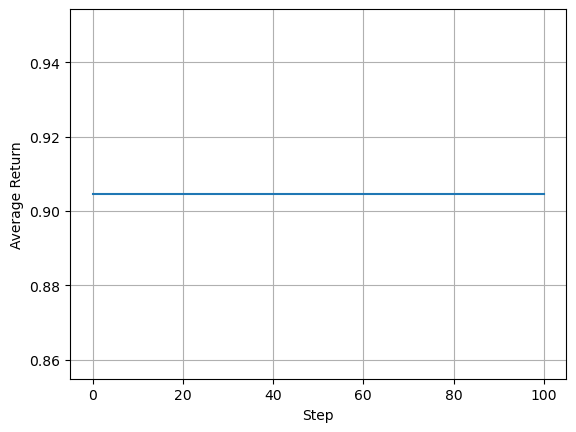

In [24]:
import matplotlib.pyplot as plt

steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.grid()
plt.ylim()

(-0.11065889596939088, 2.3238368153572084)

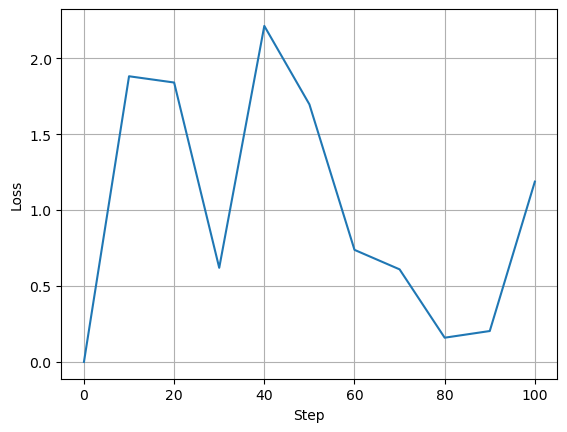

In [23]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, losses)
plt.ylabel('Loss')
plt.xlabel('Step')
plt.grid()
plt.ylim()